In [1]:
import gc
import numpy as np
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Input,Model,optimizers
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, UpSampling1D,Activation
from tensorflow.keras.layers import MaxPooling1D, BatchNormalization, Flatten,GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

import pandas as pd
import random
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, classification_report,plot_confusion_matrix
import glob
from tqdm import tqdm
import os
import itertools

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('memory growth:', tf.config.experimental.get_memory_growth(physical_devices[0]))
else:
    print("Not enough GPU hardware devices available")

/home/m-shiota/.pyenv/versions/miniconda3-4.3.30/envs/micresearch36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/m-shiota/.pyenv/versions/miniconda3-4.3.30/envs/micresearch36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/m-shiota/.pyenv/versions/miniconda3-4.3.30/envs/micresearch36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'

memory growth: True


In [2]:
VAL_RATE = 0.9

In [16]:
#define
EPOCH = 3000
BATCH_SIZE = 256
MINIBATCH = 64
DROP_RATE = 0.5

FC_SIZE = 50
FILTER_SIZE = 64

DATA_START = 250
DATA_LEN = 4096

IN_DIR_PATH = "sa321_y"

os.makedirs('../logs/'+IN_DIR_PATH+'/events',exist_ok=True)

In [17]:
# input_dir and out_dir
input_dir_path = "../preprocessed/train_"+IN_DIR_PATH+"/*/*.csv"
input_dir = glob.glob(input_dir_path)
input_num = len(input_dir)

class_list = np.array([])
all_data = np.array([])
all_label = np.array([])

init_flg = True

for d in tqdm(input_dir):
    # print(d)
    if ".DS_Store" in d:
        os.remove(d)
        input_dir.remove(d)
        continue
    
    end_index = d.rfind('/')
    start_index = d[:end_index].rfind('/')
    class_name = d[start_index+1:end_index]
    if class_name not in class_list:
        class_list = np.append(class_list,class_name)
        # print(class_name)
    
    label = np.where(class_list == class_name)
    all_label = np.append(all_label,label)
    
    data = np.loadtxt(d, delimiter=",")
    
    # axis_time = np.vstack(data[DATA_START:DATA_START+DATA_LEN,0])
    axis_value = np.hstack([data[DATA_START:DATA_START+DATA_LEN, 1]])
    
    # preprocessed = np.hstack([axis_time,axis_value])
    if init_flg:
        all_data = axis_value
        init_flg = False
    else:
        all_data = np.vstack([all_data,axis_value])

100%|██████████| 976/976 [00:41<00:00, 23.52it/s]


In [5]:
one_hot_label = to_categorical(all_label,class_list.shape[0])

p = np.random.permutation(input_num)
shuffled_data = all_data[p]
shuffled_label = one_hot_label[p]

trainX = shuffled_data[:int(input_num*VAL_RATE)]
valX = shuffled_data[int(input_num*VAL_RATE):]
trainY = shuffled_label[:int(input_num*VAL_RATE)]
valY = shuffled_label[int(input_num*VAL_RATE):]

trainX = np.reshape(trainX,(int(input_num*VAL_RATE),DATA_LEN,1)).astype(np.float32)
valX = np.reshape(valX,(input_num-int(input_num*VAL_RATE),DATA_LEN,1)).astype(np.float32)
# trainY = np.reshape(trainY,(int(input_num*VAL_RATE),class_list.shape[0],1))
# valY = np.reshape(valY,(input_num-int(input_num*VAL_RATE),class_list.shape[0],1))

In [6]:
print(trainX.shape)
print(trainY.shape)

(878, 4096, 1)
(878, 9)


In [7]:
def Mynet():
    inputs = Input(shape=(DATA_LEN,1))
    # Due to memory limitation, images will resized on-the-fly.
    x = Conv1D(FILTER_SIZE, 5, padding='same', input_shape=(DATA_LEN,1), activation=None)(inputs)
    x = Conv1D(FILTER_SIZE, 5, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(DROP_RATE)(x)

    x = Conv1D(FILTER_SIZE*2, 5, padding='same')(x)
    x = Conv1D(FILTER_SIZE*2, 5, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(DROP_RATE)(x)
    
    x = Conv1D(FILTER_SIZE*4, 5, padding='same')(x)
    x = Conv1D(FILTER_SIZE*4, 5, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(DROP_RATE)(x)
    
    fc = Flatten()(x)
    fc = Dense(FC_SIZE*2, activation='relu')(fc)
    fc = BatchNormalization()(fc)
    fc = Dropout(DROP_RATE)(fc)
    
    fc = Dense(FC_SIZE, activation='relu')(fc)
    fc = BatchNormalization()(fc)
    fc = Dropout(DROP_RATE)(fc)
    
    fc = Dense(class_list.shape[0])(fc)
    softmax = Activation('softmax')(fc)
    model = Model(inputs=inputs, outputs=softmax)
    
    return model

In [8]:
def Mynet_squeeze():
    inputs = Input(shape=(DATA_LEN,1))
    # Due to memory limitation, images will resized on-the-fly.
    x = Conv1D(FILTER_SIZE, 5, padding='same', input_shape=(DATA_LEN,1), activation='relu')(inputs)
    x = Conv1D(FILTER_SIZE, 5, padding='same',activation='relu')(x)
#     x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(int(FILTER_SIZE*2), 5, padding='same',activation='relu')(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(DROP_RATE)(x)
    x = Conv1D(int(FILTER_SIZE), 5, padding='same', activation='relu')(x)
#     x = BatchNormalization()(x)
    
    fc = GlobalMaxPooling1D()(x)
    fc = Dropout(DROP_RATE)(fc)
    fc = Flatten()(fc)
    fc = Dense(class_list.shape[0])(fc)
    softmax = Activation('softmax')(fc)
    model = Model(inputs=inputs, outputs=softmax)
    
    return model

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('../logs/'+IN_DIR_PATH+'/cm.png')

In [13]:
model = Mynet_squeeze()
model.summary()
model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.006, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
             metrics=['accuracy'])

history = model.fit(trainX,trainY, 
                    epochs=3000, 
                    batch_size=BATCH_SIZE, 
                    verbose=1, 
                    validation_split=0.2,
                    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='../logs/'+IN_DIR_PATH+'/events', histogram_freq=10)#,
#                                tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=700,verbose=0,mode='auto')
                              ]
                   )

score = model.evaluate(valX, valY, batch_size=BATCH_SIZE, verbose=0)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4096, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 4096, 64)          384       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4096, 64)          20544     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2048, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2048, 128)         41088     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1024, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1024, 128)         0     

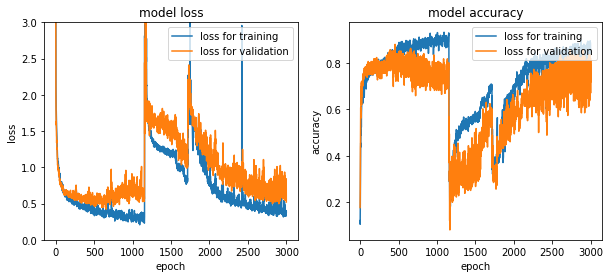

In [14]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))

# loss
def plot_history_loss(fit):
    # Plot the loss in the history
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.set_ylim([0,3])
    axL.legend(loc='upper right')

# acc
def plot_history_acc(fit):
    # Plot the loss in the history
    axR.plot(fit.history['acc'],label="loss for training")
    axR.plot(fit.history['val_acc'],label="loss for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='upper right')

plot_history_loss(history)
plot_history_acc(history)
plt.show()
fig.savefig('../logs/'+IN_DIR_PATH+'/loss_acc.png')
plt.close()

Confusion matrix, without normalization
[[ 7  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0]
 [ 0  0 21  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0]
 [ 1  0  0  0  4  0  1  0  1]
 [ 0  0  0  0  6  6  0  0  0]
 [ 0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  3  0  0  5  3]
 [ 2  0  0  0  0  0  0  0 12]]


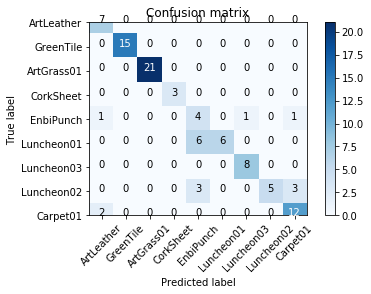

/home/m-shiota/.pyenv/versions/miniconda3-4.3.30/envs/micresearch36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:564: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/home/m-shiota/.pyenv/versions/miniconda3-4.3.30/envs/micresearch36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m-shiota/.pyenv/versions/miniconda3-4.3.30/envs/micresearch36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

71949

In [15]:
pred_y = model.predict(valX)
pred_y_c = np.argmax(pred_y,axis=1)
# pred_y_one_hot = np.identity(len(class_list))[pred_y_c]
true_y = np.argmax(valY,axis=1)
confusion_mtx = confusion_matrix(true_y, pred_y_c) 
plot_confusion_matrix(confusion_mtx, classes=class_list)
plt.show()
cr = classification_report(true_y,pred_y_c,labels=class_list)
f = open('../logs/'+IN_DIR_PATH+'/cr.txt','w')
f.write(cr)
f.close()

keras.backend.clear_session()
gc.collect()

array([6, 0, 1, 0, 2, 8, 8, 7, 3, 2, 1, 4, 2, 0, 2, 1, 2, 8, 6, 4, 4, 7,
       1, 1, 0, 7, 7, 1, 2, 1, 1, 4, 0, 4, 3, 2, 0, 4, 1, 0, 3, 4, 7, 0,
       4, 1, 6, 6, 8, 0, 0, 1, 6, 4, 8, 2, 2, 2, 4, 2, 1, 0, 8, 8, 7, 2,
       8, 3, 1, 3, 2, 2, 6, 8, 3, 8, 8, 3, 3, 6, 8, 4, 0, 4, 7, 6, 6, 0,
       2, 8, 3, 7, 3, 2, 6, 2, 7, 7])

(array([6, 0, 1, 0, 2, 8, 8, 7, 3, 2, 1, 7, 2, 0, 2, 1, 2, 8, 6, 5, 7, 7,
        1, 1, 4, 7, 7, 1, 2, 1, 1, 5, 8, 7, 3, 2, 0, 7, 1, 0, 3, 5, 7, 4,
        5, 1, 6, 6, 4, 4, 8, 1, 6, 5, 8, 2, 2, 2, 5, 2, 1, 0, 8, 8, 5, 2,
        5, 3, 1, 3, 2, 2, 6, 8, 3, 8, 8, 6, 3, 6, 8, 4, 0, 5, 7, 6, 6, 0,
        2, 8, 3, 7, 3, 2, 6, 2, 5, 7]),)

(98,)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -3,  0,  0,  0,  0,  0,
        0,  0, -1, -3,  0,  0,  0, -4,  0,  0,  0,  0,  0,  0, -1, -8, -3,
        0,  0,  0, -3,  0,  0,  0, -1,  0, -4, -1,  0,  0,  0,  4, -4, -8,
        0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  2,  0,  3,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -3,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0])